In [2]:
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
from sklearn import svm
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import cv2
import os
import re
!pip install pydicom
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
import utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained = True,num_classes =6)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 235MB/s]


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [8]:
from pascal_dataset import PASCALDataset
datasetTrain = PASCALDataset("/content/drive/MyDrive/pascal/PASCAL/train")
datasetTest = PASCALDataset("/content/drive/MyDrive/pascal/PASCAL/test")
datasetVal = PASCALDataset("/content/drive/MyDrive/pascal/PASCAL/val")

In [9]:
from engine import train_one_epoch
from engine import evaluate

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
epochs=5
iou_threshold=5
batch_size=4

In [11]:
train_loader = torch.utils.data.DataLoader(datasetTrain, batch_size=4, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
test_loader = torch.utils.data.DataLoader(datasetTest, batch_size=4, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
val_loader = torch.utils.data.DataLoader(datasetVal, batch_size=1, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train

In [12]:
for epoch in range(5):
        train_one_epoch(model.cuda(), optimizer, train_loader, device, epoch, print_freq=10)
        evaluate(model.cuda(), test_loader, device=device)



Epoch: [0]  [  0/247]  eta: 1:20:33  lr: 0.000005  loss: 0.3952 (0.3952)  loss_classifier: 0.2616 (0.2616)  loss_box_reg: 0.1207 (0.1207)  loss_objectness: 0.0053 (0.0053)  loss_rpn_box_reg: 0.0076 (0.0076)  time: 19.5689  data: 12.1184  max mem: 4895
Epoch: [0]  [ 10/247]  eta: 0:11:34  lr: 0.000046  loss: 0.2060 (0.2066)  loss_classifier: 0.0844 (0.0963)  loss_box_reg: 0.1004 (0.0904)  loss_objectness: 0.0046 (0.0053)  loss_rpn_box_reg: 0.0111 (0.0146)  time: 2.9308  data: 1.1385  max mem: 6792
Epoch: [0]  [ 20/247]  eta: 0:08:08  lr: 0.000086  loss: 0.2172 (0.2168)  loss_classifier: 0.0947 (0.0936)  loss_box_reg: 0.1034 (0.1022)  loss_objectness: 0.0045 (0.0060)  loss_rpn_box_reg: 0.0136 (0.0150)  time: 1.2791  data: 0.0278  max mem: 7646
Epoch: [0]  [ 30/247]  eta: 0:06:46  lr: 0.000127  loss: 0.2172 (0.2097)  loss_classifier: 0.0834 (0.0895)  loss_box_reg: 0.1081 (0.0997)  loss_objectness: 0.0045 (0.0058)  loss_rpn_box_reg: 0.0137 (0.0147)  time: 1.2935  data: 0.0152  max mem: 764

In [13]:
evaluate(model=model, data_loader=datasetVal, device=device)

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:52  model_time: 0.5944 (0.5944)  evaluator_time: 0.0079 (0.0079)  time: 1.0422  data: 0.4210  max mem: 8205
Test:  [49/50]  eta: 0:00:00  model_time: 0.5092 (0.5503)  evaluator_time: 0.0044 (0.0062)  time: 0.5563  data: 0.0154  max mem: 8205
Test: Total time: 0:00:29 (0.5873 s / it)
Averaged stats: model_time: 0.5092 (0.5503)  evaluator_time: 0.0044 (0.0062)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.585
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.878
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.646
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.521
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.678
 Average Recall     (AR) @[ IoU=

Results

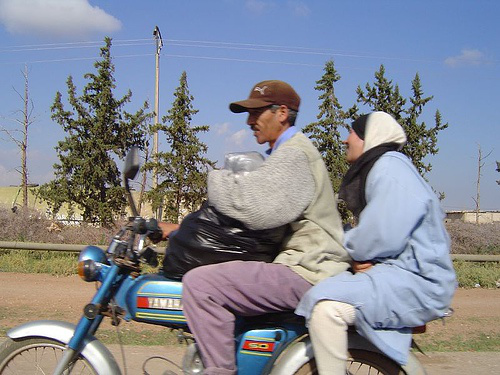

In [98]:
import PIL
image_1 = PIL.Image.open("/content/drive/MyDrive/pascal/PASCAL/test/Images/2008_006152.jpg").convert("RGB")
display(image_1)

In [99]:
tensorImage1 = torchvision.transforms.functional.to_tensor(image_1)

In [100]:
list_img1 = [tensorImage1.to(device)]

In [101]:
model.eval()
with torch.no_grad():
  prediction = model(list_img1)

In [103]:
boxes = prediction[0]["boxes"].cpu()
labels = prediction[0]["labels"].cpu()
scores = prediction[0]["scores"].cpu()

In [106]:
background,human, bicycle, car, motorcycle, airplane = 0, 0, 0, 0, 0, 0
labelName = ["background","human", "bicycle", "car", "motorcycle", "airplane"] 
idx = np.where(scores > 0.8)
lbal = []
for i in idx :
  lbal.append(labels[i])

for b in lbal[0] :
  if b == 0 :
    background = background + 1
  if b == 1 :
    human = human +1
  if b == 2 :
    bicycle = bicycle +1
  if b == 3 :
    car = car +1
  if b == 4 :
    motorcycle = motorcycle +1
  if b == 5 :
    airplane = airplane +1
model_label = [background,human, bicycle, car, motorcycle, airplane]
true_label = []
for s in zip(labelName, model_label) :
  if s[1] > 0 :
    true_label.append(s)
true_label

[('human', 2), ('motorcycle', 1)]

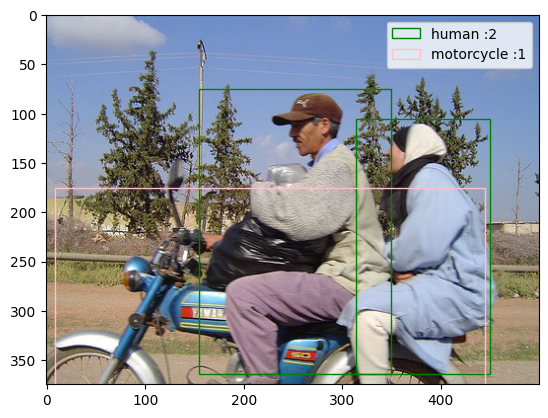

In [107]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
np_arr = tensorImage1.permute(1,2,0).numpy()
plt.imshow(np_arr)

ax = plt.gca()
for box, label, score in zip(boxes, labels, scores):
  if score > 0.8 :
    if label == 0 :
      color = "black"
    if label ==1 :
      color = "green"
    if label ==2 :
      color = "red"
    if label == 3 :
      color = "yellow"
    if label == 4 :
      color = "pink"
    if label == 5 :
      color = "orange"
    rect = Rectangle((box[0],box[1]),(box[2]-box[0]),(box[3]-box[1]),fill = False,color = color)
    ax.add_patch(rect)
xx=[]
for c in true_label :
  if c[0] == "background":
    color = "black"
  if c[0] =="human" :
      color = "green"
  if c[0]=="bicycle" :
      color = "red"
  if c[0] == "car" :
      color = "yellow"
  if c[0] == "motorcycle" :
      color = "pink"
  if c[0] == "airplane":
      color = "orange"
  xx.append(mpatches.Patch(color=color, label=f"{c[0]} :{c[1]}", fill = False))


import matplotlib.patches as mpatches
plt.legend(handles=xx)
plt.show() 

In [108]:
import scipy.io 
mat = scipy.io.loadmat("/content/drive/MyDrive/pascal/PASCAL/test/BBox/2008_006152_bbox.mat")
mat
label = scipy.io.loadmat("/content/drive/MyDrive/pascal/PASCAL/test/Labels/2008_006152_label.mat")

In [109]:
background,human, bicycle, car, motorcycle, airplane = 0, 0, 0, 0, 0, 0
for i in label["labels"][0] :
  if i == 0 :
    background = background + 1
  if i == 1 :
    human = human +1
  if i == 2 :
    bicycle = bicycle +1
  if i == 3 :
    car = car +1
  if i == 4 :
    motorcycle = motorcycle +1
  if i == 5 :
    airplane = airplane +1
lbl = [background,human, bicycle, car, motorcycle, airplane]
all_label = ["background","human", "bicycle", "car", "motorcycle", "airplane"]
iss = []
for k in zip(all_label,lbl) :
  if k[1] > 0 :
    iss.append(k)
 

In [110]:
image_2 = PIL.Image.open("/content/drive/MyDrive/pascal/PASCAL/test/Images/2008_006152.jpg").convert("RGB")


In [111]:
tensorImage2 = torchvision.transforms.functional.to_tensor(image_2)
list_img2 = [tensorImage2.to(device)]
np_arr = tensorImage2.permute(1,2,0).numpy()


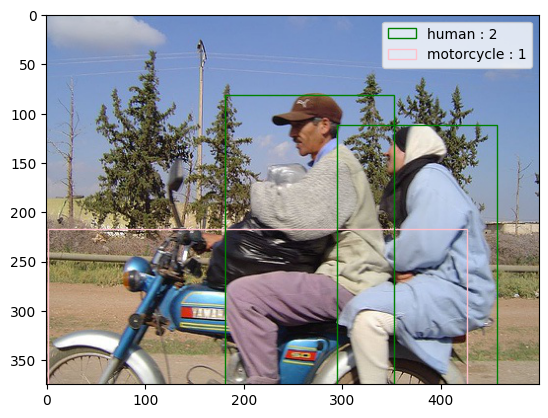

In [112]:
from matplotlib.patches import Rectangle
tensorImage2 = torchvision.transforms.functional.to_tensor(image_2)
list_img2 = [tensorImage2.to(device)]
np_arr = tensorImage2.permute(1,2,0).numpy()
plt.imshow(np_arr)
ax2 = plt.gca()
for n in zip(mat["bboxes"],label["labels"][0]):
  tensorImage2 = torchvision.transforms.functional.to_tensor(image_2)
  list_img2 = [tensorImage2.to(device)]
  np_arr = tensorImage2.permute(1,2,0).numpy()
  if n[1] ==1 :
      color = "green"
  if n[1] == 0 :
    color = "black"
  if n[1]==2 :
      color = "red"
  if n[1] == 3 :
      color = "yellow"
  if n[1] == 4 :
      color = "pink"
  if n[1] == 5 :
      color = "orange"
  rect = Rectangle((n[0][0],n[0][1]),(n[0][2]-n[0][0]),(n[0][3]-n[0][1]),fill = False,color = color)
  ax2.add_patch(rect)
pop=[]
for v in iss :
  if v[0] == "background" :
    color ="black"
  if v[0] =="human" :
      color = "green"
  if v[0]=="bicycle" :
      color = "red"
  if v[0] == "car" :
      color = "yellow"
  if v[0] == "motorcycle" :
      color = "pink"
  if v[0] == "airplane":
      color = "orange"
  pop.append(mpatches.Patch(color=color, label=f"{v[0]} : {v[1]}",fill = False))


import matplotlib.patches as mpatches

plt.legend(handles=pop)
plt.show()
